In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import rankdata, zscore
import os
import joblib
from pygeneconverter import ensembl_to_hugo
import tensorflow as tf

In [75]:
model = tf.keras.models.load_model('/data1/Projects/Hallmark/hallmark_model.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9326)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    596,928 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         17 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         17 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         17 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         17 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         17 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         17 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         17 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │         17 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         17 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,822,496 (6.95 MB)

 Trainable params: 607,498 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,214,998 (4.63 MB)

In [4]:
scaler = joblib.load('/data1/Projects/Hallmark/hallmark_scaler.joblib')
scaler

StandardScaler()

In [5]:
with open('/data1/Projects/Hallmark/hallmark_feature.txt', 'r') as file:
    feature_name = file.read().splitlines()
len(feature_name)

9326

In [6]:
hall_list = ['AIM', 'DCE', 'EGS', 'GIM', 'RCD', 'SPS', 'AID', 'IA', 'ERI', 'TPI']

# Model Sensitivity (true positive rate) check on metastasis cancer MET500 datasets

In [22]:
met = pd.read_csv('M.mx.txt', sep='\t', index_col=0)
met.index = met.index.str.split('.').str[0]
met_gene = ensembl_to_hugo(met.index).set_index('ENSEMBL_ID')
met_gene = met_gene[['HGNC_ID']]
met = pd.concat([met_gene, met], axis=1).dropna().set_index('HGNC_ID')
met

,ES_5001-capt-SI_5013-C0LAMACXX,ES_5004-capt-SI_5834-C19KEACXX,ES_5004-poly-SI_5767-C19KEACXX,ES_5005-capt-SI_5505-D130HACXX,ES_5005-poly-SI_5486-D12YGACXX,MO_1001-poly-SI_4110-D0CG3ABXX,MO_1002-poly-SI_4111-D0CG3ABXX,MO_1005-poly-SI_4154-C0282ABXX,MO_1007-poly-SI_4349-D07RMACXX,MO_1008-capt-SI_4519-D0EN5ACXX,...,TP_2120-capt-SI_11542-HV7FKADXX,TP_2120-poly-SI_11533-HV7JLADXX,TP_2122-capt-SI_11543-C7GBMANXX,TP_2122-poly-SI_11534-C7GBMANXX,TP_2123-capt-SI_11731-C7G60ANXX,TP_2123-poly-SI_11689-C7G60ANXX,TP_2130-capt-SI_11905-C7FMDANXX,TP_2131-capt-SI_11906-C7F4VANXX,TP_2141-capt-SI_12056-H53C5ADXX,TP_2156-capt-SI_12477-C7G91ANXX
HGNC_ID,,,,,,,,,,,,,,,,,,,,,
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017861,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMD11,5.898170,17.818274,0.198395,20.062676,19.377980,2.826194,1.723496,9.707424,39.631572,6.310030,...,0.347653,0.291487,0.402601,0.688779,0.181268,0.173120,0.116035,0.136936,3.223771,0.314334
NOC2L,30.316540,22.250822,5.133513,120.890851,123.847565,31.152552,55.312780,26.188456,42.339461,51.373995,...,32.048410,36.444654,28.863697,31.788150,16.197740,16.943805,24.842154,17.135107,27.155874,23.695564
KLHL17,3.556271,8.926017,0.250987,49.872972,65.602834,11.127009,6.798288,7.874456,28.207056,2.936076,...,4.172864,4.043395,4.650856,4.469400,1.370683,1.054502,4.799049,3.028936,5.164165,2.866125
PLEKHN1,3.374429,4.104587,0.079358,1.692241,2.207360,5.593045,6.348879,0.587193,25.623242,2.757619,...,0.191457,0.112504,2.182719,2.571930,0.040626,0.038471,3.661471,5.783500,3.488580,1.317469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUTA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SYNGAP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZBTB9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
met1 = met.T
met1 = met1.loc[:, ~met1.columns.duplicated(keep='first')]
met1 = met1.reindex(columns = feature_name, fill_value = 0).fillna(0)
met1_index = met1.index
met1 = rankdata(met1 * -1, axis=1, method='average')
met1 = np.log2(met1)
met1 = scaler.transform(met1)
met1

array([[ 0.64013682,  1.23506545,  0.62425975, ...,  1.49985878,
         1.54441036,  0.24387756],
       [-0.41226915,  0.24591918,  0.31477789, ...,  0.68291315,
         1.39080487, -5.79466269],
       [ 0.04124531, -3.62776206, -0.58964825, ...,  1.49150961,
         2.61831545, -5.246864  ],
       ...,
       [ 0.81486489, -0.1981024 , -0.30758136, ...,  0.48110736,
         0.3404379 , -4.72081061],
       [ 0.60596513,  0.63609801,  0.33142026, ..., -0.92806127,
         1.06996487, -2.70850846],
       [ 0.36400702,  0.41851763, -1.6771255 , ...,  0.75133379,
         0.29831095, -1.26132897]])

In [24]:
met_pred = model.predict(met1)
met_pred_df = pd.DataFrame()

for task_id in range(10):
    pred = np.array(met_pred[task_id]).flatten()
    met_pred_df[f'task_{task_id}'] = pred

met_pred_df.columns = hall_list
met_pred_df.index = met1_index
met_pred_df

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


,AIM,DCE,EGS,GIM,RCD,SPS,AID,IA,ERI,TPI
ES_5001-capt-SI_5013-C0LAMACXX,0.999874,9.999049e-01,0.999881,0.993468,0.999984,9.999964e-01,0.999436,0.999931,0.999993,0.999986
ES_5004-capt-SI_5834-C19KEACXX,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
ES_5004-poly-SI_5767-C19KEACXX,0.000040,2.339933e-07,0.000009,0.000005,0.000003,6.088181e-07,0.000061,0.000002,0.000003,0.000187
ES_5005-capt-SI_5505-D130HACXX,0.997479,9.984610e-01,0.999710,0.999788,0.999927,9.998451e-01,0.996767,0.999815,0.953907,0.999733
ES_5005-poly-SI_5486-D12YGACXX,0.016456,7.769047e-02,0.278799,0.543992,0.650945,2.026175e-01,0.115444,0.626185,0.003570,0.056553
...,...,...,...,...,...,...,...,...,...,...
TP_2123-poly-SI_11689-C7G60ANXX,0.000337,8.495366e-05,0.001312,0.000619,0.000313,1.749409e-04,0.000410,0.000177,0.000009,0.000714
TP_2130-capt-SI_11905-C7FMDANXX,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
TP_2131-capt-SI_11906-C7F4VANXX,0.969715,9.925540e-01,0.998941,0.998510,0.954897,9.730487e-01,0.962522,0.997797,0.988657,0.996097
TP_2141-capt-SI_12056-H53C5ADXX,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000


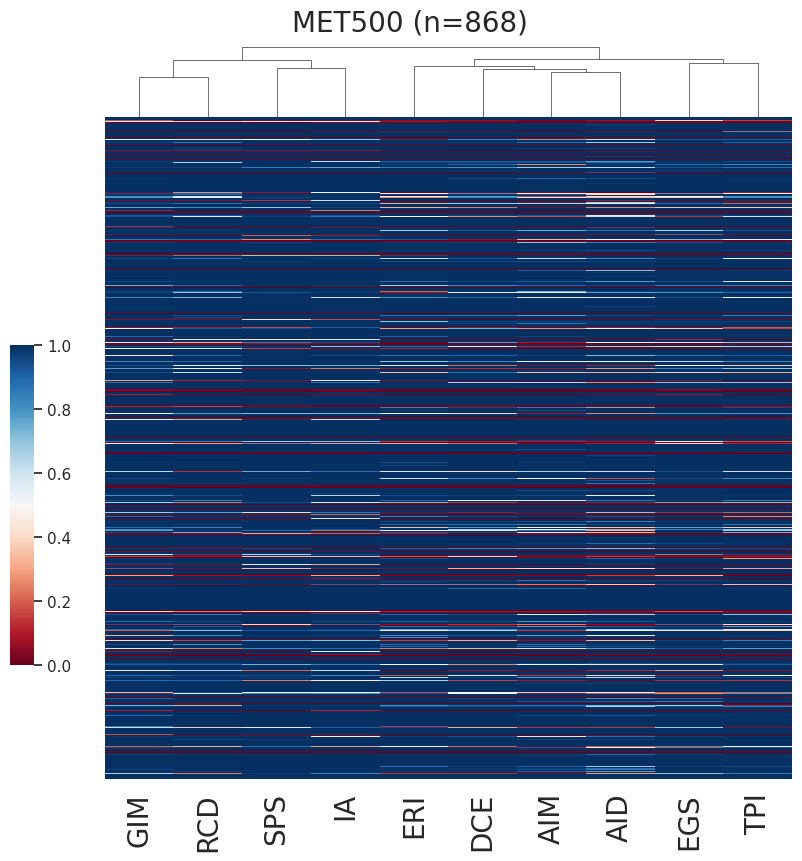

In [115]:
cluster = sns.clustermap(met_pred_df.sample(frac=1, random_state=42), annot=False, cmap = 'RdBu', vmin=0, vmax=1, figsize=(8, 8),
               annot_kws={"size": 35}, row_cluster=False, cbar_kws={"shrink": 1}, dendrogram_ratio=0.1,
                        cbar_pos=(0, .2, .03, .4), yticklabels=False)
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90)
cluster.fig.suptitle("MET500 (n=868)", fontsize=20, y=1.02)
plt.savefig('met500_pred_heat.png', dpi=1200, bbox_inches='tight')

In [25]:
met_pred_df.to_csv('met500_pred.csv')

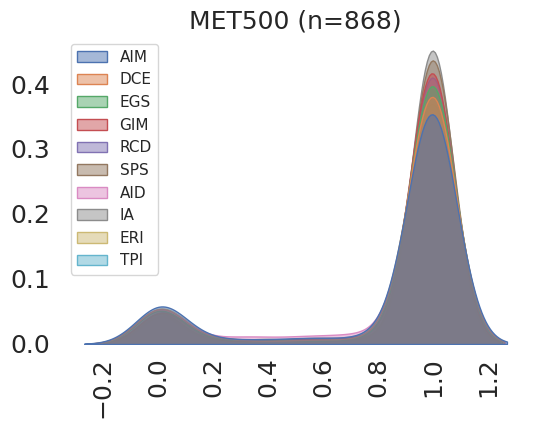

In [26]:
sns.set_theme(style="white")
plt.figure(figsize=(6, 4))

sns.kdeplot(met_pred_df, fill=True, alpha=0.5, linewidth=1)
# plt.xlabel("Predicted Probability", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=16, labelpad=10)
plt.title("MET500 (n=868)", fontsize=18, pad=5)

plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

sns.despine(left=True, bottom=True)
# plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.savefig('met500_kde.png', dpi=1200, bbox_inches='tight')
plt.show()

# Model Specificity (true negative rate) check on normal GTeX datasets

In [27]:
folder_path = '/data1/Projects/Hallmark/val_data/GTEX_DATA'
gtex_list = []
for file in os.listdir(folder_path):
    df = pd.read_csv(os.path.join(folder_path, file), sep='\t', index_col=1, header=2)
    df = df.iloc[:,1:]
    gtex_list.append(df)

In [28]:
gtex = pd.concat(gtex_list, axis=1)
gtex

,GTEX-N7MS-1526-SM-HAUZP,GTEX-P4QS-1226-SM-HPAG8,GTEX-QEG4-1526-SM-GPRWK,GTEX-QEG5-2026-SM-H6Q6I,GTEX-R55E-2026-SM-EZ6L1,GTEX-RU72-1926-SM-EAZ3F,GTEX-S33H-1526-SM-GQ1CB,GTEX-SIU8-1926-SM-H7OG4,GTEX-T5JC-1626-SM-EZ6KW,GTEX-T6MN-1926-SM-GOQYD,...,GTEX-ZE7O-2226-SM-GNTC2,GTEX-ZLWG-0926-SM-4WWC3,GTEX-ZP4G-0626-SM-4WWF1,GTEX-ZPIC-1426-SM-4WWCP,GTEX-ZTPG-1926-SM-HAUZ1,GTEX-ZVT2-0326-SM-5E44G,GTEX-ZVT3-2626-SM-5GU5L,GTEX-ZYFG-1726-SM-5GZZB,GTEX-ZYY3-2726-SM-5EGH4,GTEX-ZZPU-2126-SM-5EGIU
Description,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0,1,0,0,4,0,0,2,0,0,...,0,2,0,0,0,0,0,0,1,0
WASH7P,61,143,225,196,187,70,146,180,121,135,...,302,204,126,161,212,95,271,106,189,81
MIR6859-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR1302-2HG,0,1,1,0,0,0,0,0,0,1,...,0,0,0,1,0,1,1,1,0,2
FAM138A,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,76907,218101,37278,15132,58869,108118,68029,41976,66728,37036,...,6409,129875,41470,160955,33074,174382,2152,67733,7802,36073
MT-TE,12,85,5,1,9,13,12,9,12,6,...,0,43,23,52,7,73,3,26,1,15
MT-CYB,1141337,2057999,1208152,166778,1449542,1929581,1108435,1127647,1349266,1171744,...,79685,297413,385597,402274,391350,509080,22728,510387,73555,378247


In [30]:
gtex1 = gtex.T
gtex1 = gtex1.loc[:, ~gtex1.columns.duplicated(keep='first')]
gtex1 = gtex1.reindex(columns = feature_name, fill_value = 0).fillna(0)
gtex1_index = gtex1.index
gtex1 = rankdata(gtex1 * -1, axis=1, method='average')
gtex1 = np.log2(gtex1 )
gtex1 = scaler.transform(gtex1)
gtex1

array([[ 0.48623499,  0.2284226 , -0.45895676, ..., -1.50305976,
        -0.04304211,  0.40374607],
       [ 0.40053385,  0.37195521, -0.34759756, ...,  0.2677138 ,
         1.2938782 , -0.03515331],
       [ 0.35025988,  0.92445732, -0.330335  , ...,  0.68100211,
         1.24317647, -0.09006389],
       ...,
       [ 0.71868998, -0.32449524,  0.10945737, ...,  1.01871367,
         2.07366108,  0.30707477],
       [ 0.59433423,  0.60402433,  0.14568297, ...,  1.05335001,
         1.81541169,  0.31950626],
       [ 0.75829697,  0.18608049,  0.00821419, ...,  1.13338474,
         1.8668401 ,  0.25339887]])

In [31]:
gtex_pred = model.predict(gtex1)
gtex_pred_df = pd.DataFrame()

for task_id in range(10):
    pred = np.array(gtex_pred[task_id]).flatten()
    gtex_pred_df[f'task_{task_id}'] = pred

gtex_pred_df.columns = hall_list
gtex_pred_df.index = gtex1_index
gtex_pred_df

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,AIM,DCE,EGS,GIM,RCD,SPS,AID,IA,ERI,TPI
GTEX-N7MS-1526-SM-HAUZP,9.266655e-01,9.222311e-01,9.778062e-01,4.363990e-01,9.953139e-01,9.009916e-01,6.093149e-01,8.161129e-01,9.481062e-01,4.241233e-01
GTEX-P4QS-1226-SM-HPAG8,9.396890e-01,9.429520e-01,9.979470e-01,9.152501e-01,9.995905e-01,9.938299e-01,6.312126e-01,9.944192e-01,9.750788e-01,9.829476e-01
GTEX-QEG4-1526-SM-GPRWK,4.575546e-07,1.075616e-07,1.008297e-07,6.299565e-08,6.684555e-05,3.120944e-08,9.673367e-06,6.585721e-06,7.329371e-08,5.899832e-06
GTEX-QEG5-2026-SM-H6Q6I,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999971e-01,1.000000e+00,1.000000e+00,1.000000e+00
GTEX-R55E-2026-SM-EZ6L1,6.921173e-08,5.147283e-09,3.263653e-09,1.721462e-09,2.543207e-06,3.680984e-09,1.670184e-06,2.253125e-06,3.402847e-09,2.472165e-06
...,...,...,...,...,...,...,...,...,...,...
GTEX-ZVT2-0326-SM-5E44G,1.820017e-07,5.916544e-10,3.754465e-09,4.663908e-08,1.977507e-07,2.504135e-09,2.229791e-06,3.515707e-05,6.733456e-09,3.664265e-06
GTEX-ZVT3-2626-SM-5GU5L,7.735501e-11,2.093512e-13,2.853850e-13,3.540912e-13,1.859991e-10,4.851739e-13,1.797238e-10,4.423335e-09,4.454714e-12,4.469660e-08
GTEX-ZYFG-1726-SM-5GZZB,3.082424e-07,2.830534e-09,1.283651e-08,3.413478e-07,7.709580e-07,2.269800e-09,2.282861e-06,7.760209e-05,3.349300e-08,7.461518e-06
GTEX-ZYY3-2726-SM-5EGH4,1.297188e-10,9.343961e-14,1.225463e-13,1.705233e-13,7.945224e-11,1.331715e-13,2.595616e-10,1.695349e-09,2.621555e-12,3.439331e-08


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


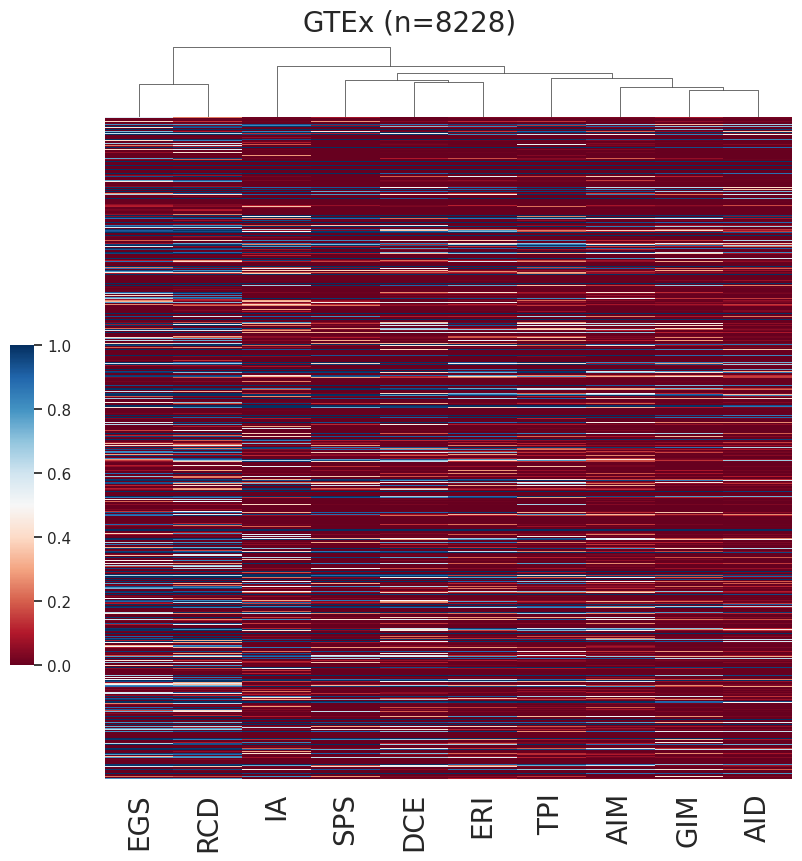

In [116]:
cluster = sns.clustermap(gtex_pred_df.sample(frac=1, random_state=42), annot=False, cmap = 'RdBu', vmin=0, vmax=1, figsize=(8, 8),
               annot_kws={"size": 35}, row_cluster=False, cbar_kws={"shrink": 1}, dendrogram_ratio=0.1,
                        cbar_pos=(0, .2, .03, .4), yticklabels=False)
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90)
cluster.fig.suptitle("GTEx (n=8228)", fontsize=20, y=1.02)
plt.savefig('gtex_pred_heat.png', dpi=1200, bbox_inches='tight')

In [32]:
gtex_pred_df.to_csv('gtex_pred.csv')

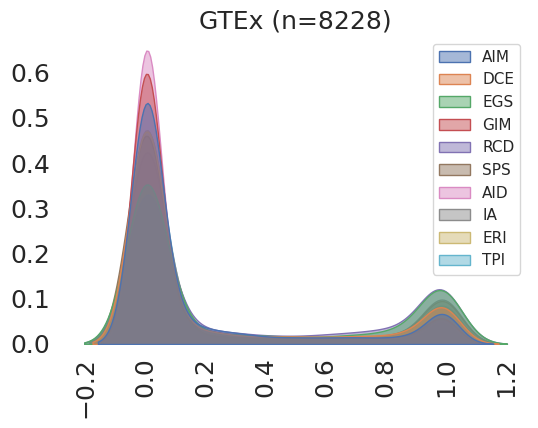

In [33]:
sns.set_theme(style="white")
plt.figure(figsize=(6, 4))

sns.kdeplot(gtex_pred_df, fill=True, alpha=0.5, linewidth=1)
# plt.xlabel("Predicted Probability", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=16, labelpad=10)
plt.title("GTEx (n=8228)", fontsize=18, pad=5)

plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

sns.despine(left=True, bottom=True)
# plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.savefig('gtex_kde.png', dpi=1200, bbox_inches='tight')
plt.show()

# Model Sensitivity (true positive rate) check on primary cancer TCGA datasets

In [34]:
tcga = pd.read_csv('/data1/Projects/Hallmark/tcga_data.tsv', sep='\t')
new_col = tcga['gene_id'].str.split('|').str[0]
tcga.drop(['gene_id'], axis=1, inplace=True)
tcga.insert(0, 'Hugo', new_col)
tcga = tcga.set_index('Hugo')
tcga = tcga[~(tcga.index).isin(['?'])]
tcga = tcga.fillna(0).astype(int)
tcga.columns = tcga.columns.str[:15]
tcga = tcga[[col for col in tcga.columns if not col[-2:] in ['10', '11', '12', '13', '14']]]
tcga.columns = tcga.columns.str[:-3]
tcga = tcga.T
tcga = tcga[~tcga.index.duplicated(keep='first')]
tcga

Hugo,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-OR-A5J1,16,0,17,182,10373,54,190,0,0,2225,...,183,146,20,351,1050,0,648,1841,1157,596
TCGA-OR-A5J2,9,0,5,239,9844,0,198,0,0,1509,...,264,438,57,279,2979,31,1166,3059,1895,801
TCGA-OR-A5J3,20,0,8,138,7201,1,75,2,0,1259,...,90,190,39,495,914,0,806,2655,1482,437
TCGA-OR-A5J5,1696,1,6,63,2939,49,374,0,0,2993,...,260,840,17,206,890,11,553,2367,1140,512
TCGA-OR-A5J6,600,0,4,237,9586,1,1556,0,0,1186,...,64,63,12,117,894,7,795,708,796,475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CG-4472,14,0,0,150,33395,0,349,23,0,433,...,292,450,79,509,1224,3,905,3359,1740,1148
TCGA-CG-4474,37,0,0,196,21828,0,198,43,0,946,...,745,1056,39,349,970,17,757,4264,2702,857
TCGA-CG-4475,16,0,0,68,20825,0,482,0,0,493,...,556,655,59,554,1308,3,927,3103,1370,473
TCGA-CG-4476,24,0,0,169,34248,0,263,90,0,454,...,516,608,45,464,1101,0,845,3302,1915,1027


In [35]:
cancer_types = ['BRCA', 'OV', 'PRAD', 'LAML', 'DLBC', 'LUAD', 'LUSC', 'SARC', 'COAD', 'READ', 'SKCM',
                'LIHC', 'KICH', 'KIRC', 'KIRP', 'HNSC', 'PAAD', 'LGG', 'GBM']

In [36]:
tcga_meta = pd.read_csv('/data1/Projects/Hallmark/patient_info.csv', index_col=(0))
tcga_meta = tcga_meta[['CANCER_TYPE_ACRONYM']]
tcga_meta = tcga_meta[tcga_meta['CANCER_TYPE_ACRONYM'].isin(cancer_types)]
tcga_meta = tcga_meta[~tcga_meta.index.duplicated(keep='first')]
tcga_meta

,CANCER_TYPE_ACRONYM
PATIENT_ID,
TCGA-2K-A9WE,KIRP
TCGA-2Z-A9J1,KIRP
TCGA-2Z-A9J2,KIRP
TCGA-2Z-A9J3,KIRP
TCGA-2Z-A9J5,KIRP
...,...
TCGA-ZP-A9D4,LIHC
TCGA-ZS-A9CD,LIHC
TCGA-ZS-A9CE,LIHC


In [37]:
common_sample = list(set(tcga.index) & set(tcga_meta.index))
len(common_sample)

6967

In [38]:
tcga1 = tcga[tcga.index.isin(common_sample)]
tcga1 = tcga1.loc[:, ~tcga1.columns.duplicated(keep='first')]
tcga1 = tcga1.reindex(columns = feature_name, fill_value = 0).fillna(0)
tcga1_index = tcga1.index
tcga1 = rankdata(tcga1 * -1, axis=1, method='average')
tcga1 = np.log2(tcga1)
tcga1 = scaler.transform(tcga1)
tcga1

array([[ 0.29651246, -0.3342612 ,  0.44211014, ..., -0.50483413,
        -0.01530657,  0.22658073],
       [-0.06749754, -0.43793085,  0.60506569, ...,  0.91112211,
         0.34220215, -0.37427212],
       [-2.42467304, -0.65334707,  0.71222468, ...,  0.01022248,
         1.22685328, -0.10644999],
       ...,
       [-0.29868969, -0.3060346 , -0.57361955, ...,  1.0984637 ,
         1.36490915,  0.42264966],
       [-0.48782752, -0.5379138 ,  0.01183635, ...,  0.74001981,
         1.21080157,  0.42291294],
       [-0.53258696, -0.54705733, -0.87178165, ...,  0.8136775 ,
         1.23031806,  0.4310594 ]])

In [40]:
tcga_pred = model.predict(tcga1)
tcga_pred_df = pd.DataFrame()

for task_id in range(10):
    pred = np.array(tcga_pred[task_id]).flatten()
    tcga_pred_df[f'task_{task_id}'] = pred

tcga_pred_df.columns = hall_list
tcga_pred_df.index = tcga1_index
tcga_pred_df

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,AIM,DCE,EGS,GIM,RCD,SPS,AID,IA,ERI,TPI
TCGA-FA-8693,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-FA-A4BB,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-FA-A4XK,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-FA-A6HN,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-FA-A6HO,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
TCGA-AB-3007,1.0,1.0,1.0,0.999998,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-AB-3008,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-AB-3009,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-AB-3011,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


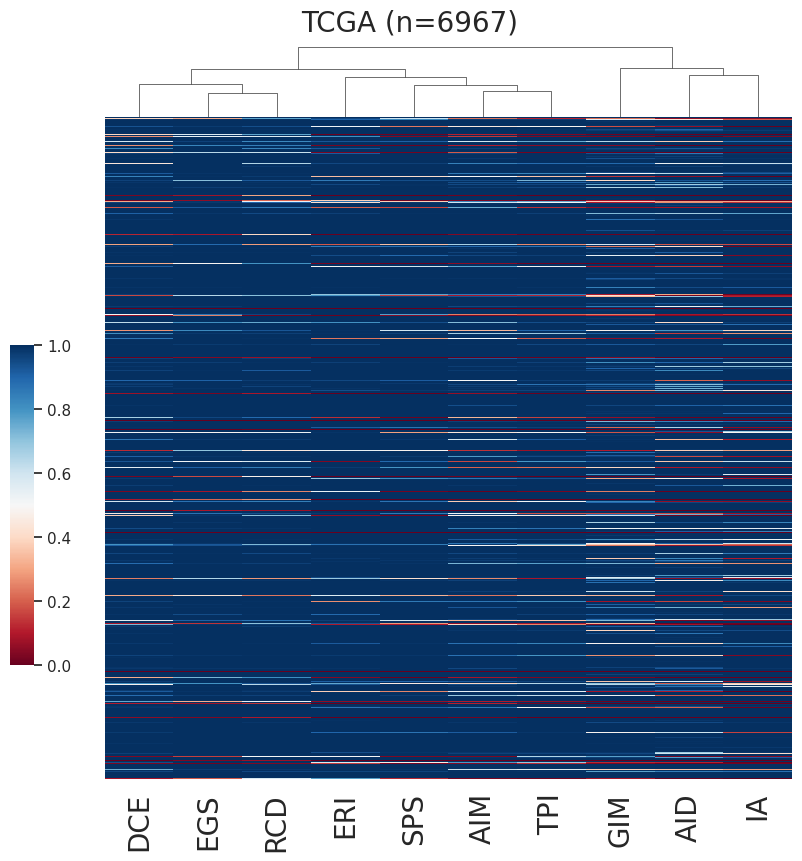

In [117]:
cluster = sns.clustermap(tcga_pred_df.sample(frac=1, random_state=42), annot=False, cmap = 'RdBu', vmin=0, vmax=1, figsize=(8, 8),
               annot_kws={"size": 35}, row_cluster=False, cbar_kws={"shrink": 1}, dendrogram_ratio=0.1,
                        cbar_pos=(0, .2, .03, .4), yticklabels=False)
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90)
cluster.fig.suptitle("TCGA (n=6967)", fontsize=20, y=1.02)
plt.savefig('tcga_pred_heat.png', dpi=1200, bbox_inches='tight')

In [41]:
tcga_pred_df.to_csv('tcga_pred.csv')

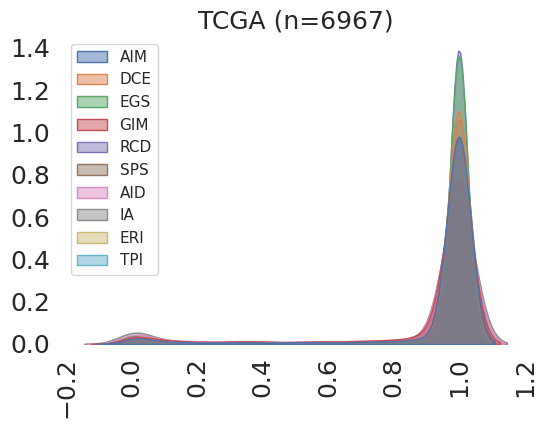

In [42]:
sns.set_theme(style="white")
plt.figure(figsize=(6, 4))

sns.kdeplot(tcga_pred_df, fill=True, alpha=0.5, linewidth=1)
# plt.xlabel("Predicted Probability", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=16, labelpad=10)
plt.title("TCGA (n=6967)", fontsize=18, pad=5)

plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

sns.despine(left=True, bottom=True)
# plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.savefig('tcga_kde.png', dpi=1200, bbox_inches='tight')
plt.show()

# Model Sensitivity (true positive rate) check on primary cancer POG570 datasets

In [44]:
folder_path = '/data1/Projects/Hallmark/val_data/POG570'
pog_list = []
for file in os.listdir(folder_path):
    df = pd.read_csv(os.path.join(folder_path, file), sep='\t', index_col=0)
    df = df[['expected_count']]
    df.columns = [file.split('_')[0]]
    pog_list.append(df)

In [45]:
pog = pd.concat(pog_list, axis=1)
pog_gene = ensembl_to_hugo(pog.index).set_index('ENSEMBL_ID')
pog_gene = pog_gene[['HGNC_ID']]
pog = pd.concat([pog_gene, pog], axis=1).dropna().set_index('HGNC_ID')
pog

,30253,25500,20801,24464,38261,25426,30248,25719,27177,23676,...,28668,23411,30519,31194,13577,30500,25657,25134,34332,25358
HGNC_ID,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
WASH7P,42.0,8.0,3.0,40.00,104.0,34.0,81.0,51.0,22.0,26.0,...,71.0,48.0,47.0,81.0,23.0,122.0,25.0,9.0,121.0,14.0
MIR1302-11,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM138A,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4G4P,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y_RNA,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WI2-2610K16.1,20.0,17.0,1.0,50.00,74.0,0.0,3.0,72.0,14.0,100.0,...,13.0,0.0,0.0,0.0,21.0,160.0,20.0,20.0,0.0,0.0
WI2-2942J8.1,2.0,0.0,12.0,0.00,7.0,3.0,5.0,0.0,4.0,0.0,...,0.0,7.0,1.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0


In [46]:
pog1 = pog.T
pog1 = pog1.loc[:, ~pog1.columns.duplicated(keep='first')]
pog1 = pog1.reindex(columns = feature_name, fill_value = 0).fillna(0)
pog1_index = pog1.index
pog1 = rankdata(pog1 * -1, axis=1, method='average')
pog1 = np.log2(pog1 )
pog1 = scaler.transform(pog1)
pog1

array([[ 0.62045731, -0.21772757,  0.32523578, ...,  1.10677809,
         1.86640489, -4.40097347],
       [ 0.53514021,  0.23001779, -1.9505443 , ..., -0.31144597,
         1.77986812, -5.48656907],
       [ 0.74836747,  0.18256754,  0.28410523, ...,  1.27008076,
         2.37484985, -3.35399366],
       ...,
       [ 0.55576884,  0.63403255,  0.48674765, ...,  0.93093794,
         1.46081531, -5.74263541],
       [ 0.55202593,  0.02511275, -1.87404488, ...,  1.1484846 ,
         1.56046243,  0.28060531],
       [ 0.79853067, -0.64019907,  0.51054727, ...,  0.99492109,
         1.76869579, -6.51210147]])

In [47]:
pog_pred = model.predict(pog1)
pog_pred_df = pd.DataFrame()

for task_id in range(10):
    pred = np.array(pog_pred[task_id]).flatten()
    pog_pred_df[f'task_{task_id}'] = pred

pog_pred_df.columns = hall_list
pog_pred_df.index = pog1_index
pog_pred_df

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,AIM,DCE,EGS,GIM,RCD,SPS,AID,IA,ERI,TPI
30253,1.000000,0.999999,1.000000,0.999916,0.999991,1.000000,0.999982,1.000000,1.000000,1.000000
25500,0.999688,0.999200,0.999426,0.986288,0.998181,0.999991,0.978481,0.998692,0.999912,0.999680
20801,1.000000,1.000000,1.000000,0.999970,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
24464,0.833943,0.937504,0.998392,0.727393,0.960645,0.999265,0.932887,0.927379,0.999788,0.949396
38261,0.000008,0.000014,0.000044,0.000667,0.000744,0.000002,0.000012,0.000111,0.000139,0.000103
...,...,...,...,...,...,...,...,...,...,...
30500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25657,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25134,0.999997,0.999995,1.000000,0.999973,0.999999,1.000000,0.999896,1.000000,1.000000,0.999999
34332,0.757910,0.341366,0.998818,0.164276,0.796665,0.958277,0.093220,0.115680,0.830133,0.677494


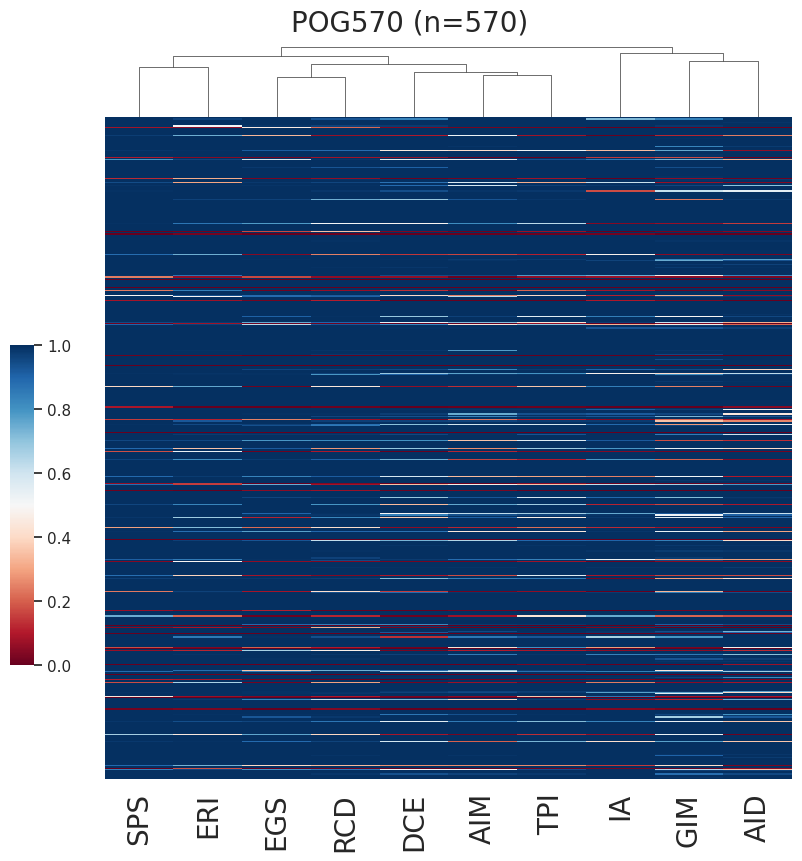

In [118]:
cluster = sns.clustermap(pog_pred_df.sample(frac=1, random_state=42), annot=False, cmap = 'RdBu', vmin=0, vmax=1, figsize=(8, 8),
               annot_kws={"size": 35}, row_cluster=False, cbar_kws={"shrink": 1}, dendrogram_ratio=0.1,
                        cbar_pos=(0, .2, .03, .4), yticklabels=False)
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90)
cluster.fig.suptitle("POG570 (n=570)", fontsize=20, y=1.02)
plt.savefig('pog_pred_heat.png', dpi=1200, bbox_inches='tight')

In [49]:
pog_pred_df.to_csv('pog_pred.csv')

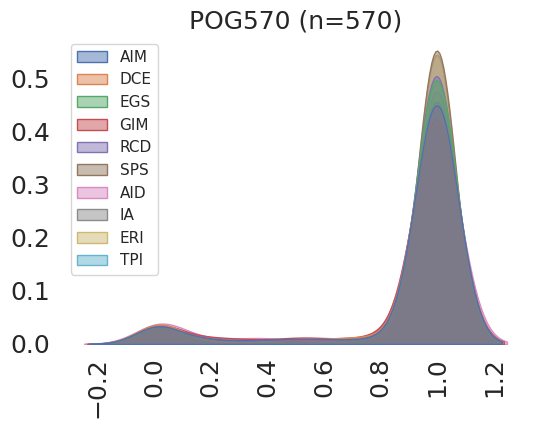

In [50]:
sns.set_theme(style="white")
plt.figure(figsize=(6, 4))

sns.kdeplot(pog_pred_df, fill=True, alpha=0.5, linewidth=1)
# plt.xlabel("Predicted Probability", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=16, labelpad=10)
plt.title("POG570 (n=570)", fontsize=18, pad=5)

plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

sns.despine(left=True, bottom=True)
# plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.savefig('pog_kde.png', dpi=1200, bbox_inches='tight')
plt.show()

# Model Sensitivity (true positive rate) check on primary cancer CCLE datasets

In [51]:
ccle = pd.read_csv('CCLE_data.gct', sep='\t', index_col=1, header=2)
ccle = ccle.iloc[:,1:]
ccle

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
Description,,,,,,,,,,,,,,,,,,,,,
DDX11L1,12,8,8,6,2,1,4,3,4,7,...,18,14,40,39,25,14,11,5,13,6
WASH7P,1340,821,678,677,884,868,611,692,639,728,...,562,328,663,270,233,558,309,811,500,945
MIR1302-11,4,1,3,3,2,6,3,4,4,2,...,11,7,24,24,20,6,3,1,6,5
FAM138A,6,3,2,4,1,4,3,1,2,3,...,14,16,31,19,24,8,7,0,10,4
OR4G4P,0,2,3,1,1,0,1,2,0,2,...,8,3,15,7,5,3,5,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,124017,112857,136078,254975,106503,92152,134020,96755,78693,101470,...,64989,55308,167546,158012,65175,56555,37417,55576,42767,159531
MT-TE,42,23,11,33,22,29,349,23,15,24,...,13,6,20,56,19,15,12,23,9,21
MT-CYB,695276,457726,250709,589478,316056,322152,302756,232040,403043,591424,...,90995,196872,850259,383806,184011,144686,85061,242084,89457,689477


In [52]:
ccle1 = ccle.T
ccle1 = ccle1.loc[:, ~ccle1.columns.duplicated(keep='first')]
ccle1 = ccle1.reindex(columns = feature_name, fill_value = 0).fillna(0)
ccle1_index = ccle1.index
ccle1 = rankdata(ccle1 * -1, axis=1, method='average')
ccle1 = np.log2(ccle1 )
ccle1 = scaler.transform(ccle1)
ccle1

array([[ 0.21105281, -1.55250139, -0.12825731, ...,  1.10286025,
         1.43522669,  0.09256087],
       [ 0.14805224, -1.62547293, -0.55598131, ...,  1.22789988,
         1.50154685, -6.46270063],
       [ 0.03881957, -0.87191886, -0.86847846, ...,  0.28987983,
         1.23882729, -5.22785196],
       ...,
       [ 0.49899056, -0.0342079 , -0.4323674 , ...,  0.86304441,
         1.65708172,  0.26443343],
       [ 0.41991884, -1.63643021,  0.37131326, ...,  0.12816049,
         1.24500359,  0.03881296],
       [ 0.12346856, -0.11644464,  0.61123085, ...,  1.17260624,
         0.99207878, -0.34290893]])

In [53]:
ccle_pred = model.predict(ccle1)
ccle_pred_df = pd.DataFrame()

for task_id in range(10):
    pred = np.array(ccle_pred[task_id]).flatten()
    ccle_pred_df[f'task_{task_id}'] = pred

ccle_pred_df.columns = hall_list
ccle_pred_df.index = ccle1_index
ccle_pred_df

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


,AIM,DCE,EGS,GIM,RCD,SPS,AID,IA,ERI,TPI
22RV1_PROSTATE,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000
2313287_STOMACH,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000
253JBV_URINARY_TRACT,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000
253J_URINARY_TRACT,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000
42MGBA_CENTRAL_NERVOUS_SYSTEM,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
YD8_UPPER_AERODIGESTIVE_TRACT,0.999999,1.000000,0.999993,0.999985,1.0,1.0,0.999974,0.999997,1.0,1.000000
YH13_CENTRAL_NERVOUS_SYSTEM,1.000000,1.000000,1.000000,0.999999,1.0,1.0,1.000000,1.000000,1.0,1.000000
YKG1_CENTRAL_NERVOUS_SYSTEM,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000
ZR751_BREAST,0.999994,0.999995,0.999977,0.999988,1.0,1.0,0.999999,0.999999,1.0,0.999997


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


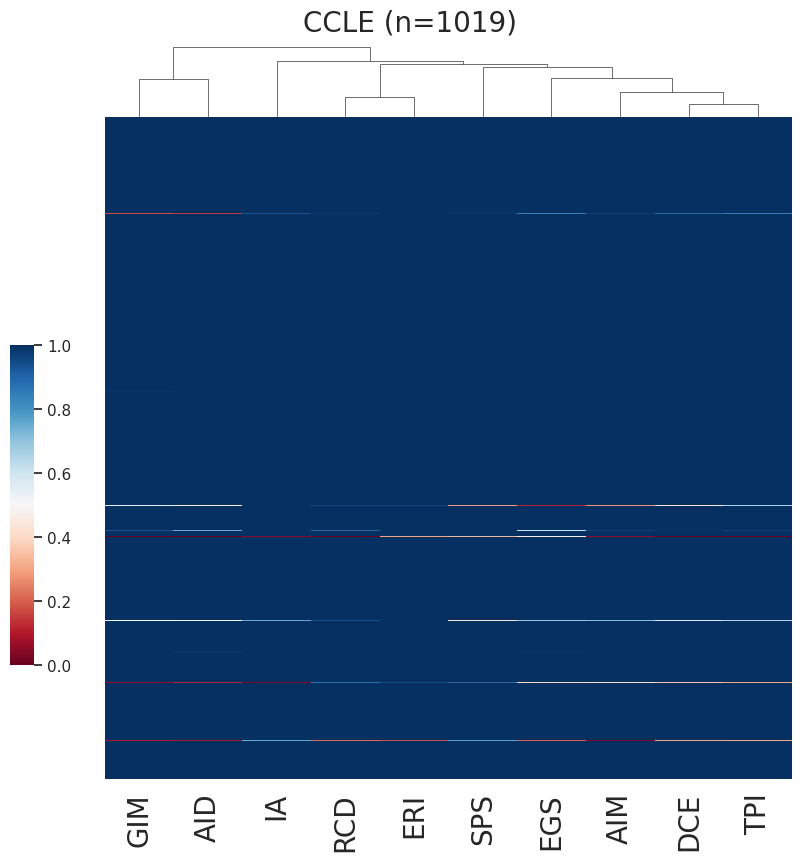

In [119]:
cluster = sns.clustermap(ccle_pred_df.sample(frac=1, random_state=42), annot=False, cmap = 'RdBu', vmin=0, vmax=1, figsize=(8, 8),
               annot_kws={"size": 35}, row_cluster=False, cbar_kws={"shrink": 1}, dendrogram_ratio=0.1,
                        cbar_pos=(0, .2, .03, .4), yticklabels=False)
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90)
cluster.fig.suptitle("CCLE (n=1019)", fontsize=20, y=1.02)
plt.savefig('ccle_pred_heat.png', dpi=1200, bbox_inches='tight')

In [54]:
ccle_pred_df.to_csv('ccle_pred.csv')

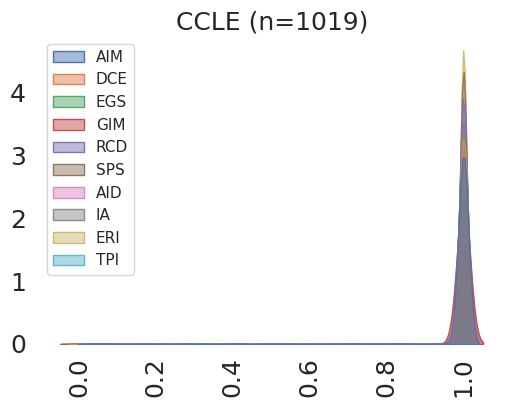

In [55]:
sns.set_theme(style="white")
plt.figure(figsize=(6, 4))

sns.kdeplot(ccle_pred_df, fill=True, alpha=0.5, linewidth=1)
# plt.xlabel("Predicted Probability", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=16, labelpad=10)
plt.title("CCLE (n=1019)", fontsize=18, pad=5)

plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

sns.despine(left=True, bottom=True)
# plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.savefig('ccle_kde.png', dpi=1200, bbox_inches='tight')
plt.show()

# Model Sensitivity (true positive rate) check on primary cancer TARGET datasets

In [56]:
target = pd.read_csv('target_data.txt', sep='\t', index_col=0)
target.index = target.index.str.split('.').str[0]
target = target[~target.index.duplicated(keep='first')]
target_gene = ensembl_to_hugo(target.index).set_index('ENSEMBL_ID')
target_gene = target_gene[['HGNC_ID']]
target = pd.concat([target_gene, target], axis=1).dropna().set_index('HGNC_ID')
target

,TARGET-30-PASWYR-01,TARGET-20-PARUBT-09,TARGET-30-PASNZU-01,TARGET-52-PASDLA-11,TARGET-50-PAKNRX-01,TARGET-30-PASWFB-01,TARGET-30-PALUYS-01,TARGET-30-PAUDDK-01,TARGET-10-PAPZNK-09,TARGET-50-PAJLNJ-01,...,TARGET-20-PANLIZ-04,TARGET-21-PASSLT-41,TARGET-20-PASTTW-09,TARGET-50-PAKYLT-01,TARGET-20-PATJHJ-09,TARGET-21-PATKKJ-41,TARGET-10-PAPEJN-04,TARGET-20-PABLDZ-09,TARGET-10-PANSBR-09,TARGET-10-PARFLV-04
HGNC_ID,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.0000,0.0000,0.0000,2.2418,4.1914,0.0000,0.0000,2.4330,0.0000,3.2234,...,0.0000,5.5326,4.4489,4.9805,0.0000,4.5298,0.0000,4.0259,4.3978,0.0000
WASH7P,9.9768,7.7874,10.8310,9.3506,9.5416,9.7886,7.9097,8.8859,8.7006,9.5699,...,10.4021,5.2388,10.1994,9.6483,10.7380,3.5777,9.8351,8.5780,10.3921,7.2897
MIR1302-11,1.9523,0.0000,0.0000,0.0000,0.0000,2.1699,2.8836,0.0000,0.0000,3.9011,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.1110,0.0000,0.7740,0.0000,0.0000
FAM138A,0.0000,0.0000,0.0000,0.0976,0.1110,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.4751,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
OR4G4P,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WI2-2610K16.1,1.5850,0.0000,0.0000,7.2095,4.2479,0.0000,3.0000,0.0000,7.3837,2.8074,...,2.5850,0.0000,1.0000,6.2095,5.7549,1.5850,8.9248,3.0000,7.1293,6.9189
WI2-2942J8.1,5.7004,2.0000,6.8455,2.5850,3.0000,5.8074,4.4594,2.5850,5.0000,1.0000,...,2.5850,4.7549,1.5850,2.8074,3.9069,3.0000,8.0112,4.0000,6.4594,4.5236
XX-CR54.3,6.2327,4.6439,3.8074,3.1699,1.0000,0.0000,2.8074,1.0000,2.0000,0.0000,...,2.0000,0.0000,3.0000,1.5850,1.5850,2.8074,1.5850,2.8074,1.0000,1.0000


In [57]:
target1 = target.T
target1 = target1.loc[:, ~target1.columns.duplicated(keep='first')]
target1 = target1.reindex(columns = feature_name, fill_value = 0).fillna(0)
target1_index = target1.index
target1 = rankdata(target1 * -1, axis=1, method='average')
target1 = np.log2(target1 )
target1 = scaler.transform(target1)
target1

array([[-0.33309736, -1.58925981,  0.58083682, ...,  1.00101758,
         1.15541013,  0.36883346],
       [-5.91743022, -2.16749443, -0.39288731, ...,  0.85160379,
         1.42325362,  0.32267232],
       [-0.83594836, -0.8411811 ,  0.68847104, ...,  0.83352609,
         1.45690954,  0.38562092],
       ...,
       [-1.65097931, -1.93659253,  0.20270381, ...,  0.58519788,
         0.44288021,  0.49571179],
       [-2.27172955, -2.83784954, -0.26591598, ...,  1.03042996,
         2.07988424,  0.50474525],
       [-5.2785176 , -2.97451733, -0.22688399, ...,  1.04321166,
         1.82037212,  0.35694034]])

In [58]:
target_pred = model.predict(target1)
target_pred_df = pd.DataFrame()

for task_id in range(10):
    pred = np.array(target_pred[task_id]).flatten()
    target_pred_df[f'task_{task_id}'] = pred

target_pred_df.columns = hall_list
target_pred_df.index = target1_index
target_pred_df

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


,AIM,DCE,EGS,GIM,RCD,SPS,AID,IA,ERI,TPI
TARGET-30-PASWYR-01,0.997773,0.999702,0.997906,0.998046,0.999661,0.999978,0.997020,0.990286,0.999951,0.999660
TARGET-20-PARUBT-09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TARGET-30-PASNZU-01,0.999980,0.999998,0.999982,0.999995,0.999998,1.000000,0.999993,0.999988,1.000000,0.999999
TARGET-52-PASDLA-11,0.473981,0.682523,0.997078,0.247936,0.978719,0.964415,0.317160,0.711366,0.690882,0.736822
TARGET-50-PAKNRX-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
TARGET-21-PATKKJ-41,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TARGET-10-PAPEJN-04,1.000000,0.999978,0.999997,0.999997,0.999980,1.000000,1.000000,0.999953,0.999998,0.999996
TARGET-20-PABLDZ-09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TARGET-10-PANSBR-09,0.999861,0.991979,0.999744,0.997908,0.997130,0.999851,0.999853,0.999649,0.999665,0.999625


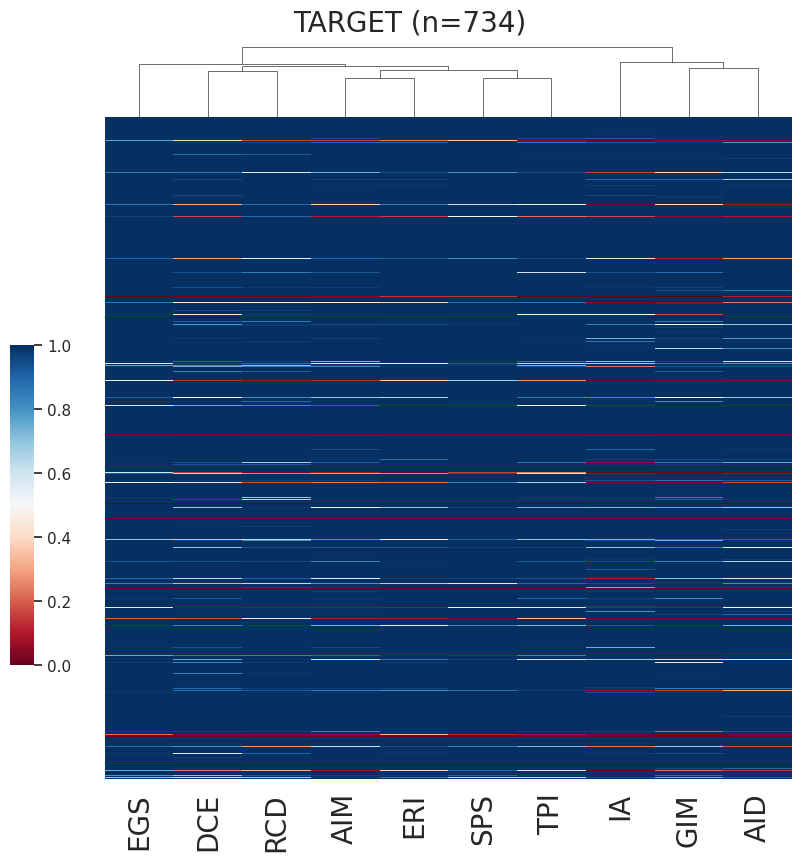

In [120]:
cluster = sns.clustermap(target_pred_df.sample(frac=1, random_state=42), annot=False, cmap = 'RdBu', vmin=0, vmax=1, figsize=(8, 8),
               annot_kws={"size": 35}, row_cluster=False, cbar_kws={"shrink": 1}, dendrogram_ratio=0.1,
                        cbar_pos=(0, .2, .03, .4), yticklabels=False)
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90)
cluster.fig.suptitle("TARGET (n=734)", fontsize=20, y=1.02)
plt.savefig('target_pred_heat.png', dpi=1200, bbox_inches='tight')

In [59]:
target_pred_df.to_csv('target_pred.csv')

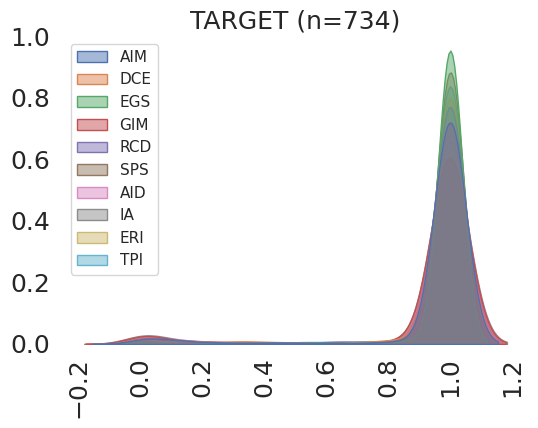

In [60]:
sns.set_theme(style="white")
plt.figure(figsize=(6, 4))

sns.kdeplot(target_pred_df, fill=True, alpha=0.5, linewidth=1)
# plt.xlabel("Predicted Probability", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=16, labelpad=10)
plt.title("TARGET (n=734)", fontsize=18, pad=5)

plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

sns.despine(left=True, bottom=True)
# plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.savefig('TARGET_kde.png', dpi=1200, bbox_inches='tight')
plt.show()

# Model Sensitivity (true positive rate) check on primary cancer PCAWG datasets

In [61]:
pcawg = pd.read_csv('pcawg_data.txt', sep='\t', index_col=0)
pcawg.index = pcawg.index.str.split('.').str[0]
pcawg = pcawg[~pcawg.index.duplicated(keep='first')]
pcawg_gene = ensembl_to_hugo(pcawg.index).set_index('ENSEMBL_ID')
pcawg_gene = pcawg_gene[['HGNC_ID']]
pcawg = pd.concat([pcawg_gene, pcawg], axis=1).dropna().set_index('HGNC_ID')
pcawg

,SP89389,SP21193,SP13206,SP103623,SP47089,SP32742,SP111095,SP8394,SP87446,SP36586,...,SP123888,SP59420,SP116679,SP1377,SP16269,SP122676,SP103189,SP88776,SP64546,SP21057
HGNC_ID,,,,,,,,,,,,,,,,,,,,,
DDX11L1,-9.9658,-9.9658,-9.9658,-9.9658,-4.7065,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-7.3368,-4.7816,-5.1343,-9.9658,-6.1965,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
WASH7P,-0.0915,-0.5424,2.3610,4.3998,1.3519,0.7852,-3.8746,0.9864,-0.3450,-0.6193,...,1.0860,2.7160,3.0708,1.5530,2.5472,1.6916,3.0082,0.8198,0.6022,-1.1790
MIR1302-11,-9.9658,-9.9658,-9.9658,-3.1507,-9.9658,-9.9658,-9.9658,-5.4516,-9.9658,-9.9658,...,-9.9658,-6.4887,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
FAM138A,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
OR4G4P,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,4.9684,8.9785,11.5006,13.5342,10.6846,11.4949,6.8831,11.6256,13.2172,8.4205,...,12.8015,11.1504,11.1079,9.7662,10.2716,9.7101,12.2507,11.7115,8.8350,8.4923
MT-TE,-1.8653,-0.0033,0.6819,-9.9658,-1.0721,-1.5551,-9.9658,2.2294,1.1591,-2.1072,...,-2.9107,-9.9658,-9.9658,-1.7909,-9.9658,-9.9658,-9.9658,-0.1720,-9.9658,-1.3988
MT-CYB,7.4863,11.6427,11.6312,14.5056,12.4587,12.0520,14.2682,12.5256,13.3406,11.0890,...,14.0455,11.4763,11.2413,12.5579,11.7356,11.4408,12.4348,11.1951,10.2972,10.6416


In [62]:
pcawg1 = pcawg.T
pcawg1 = pcawg1.loc[:, ~pcawg1.columns.duplicated(keep='first')]
pcawg1 = pcawg1.reindex(columns = feature_name, fill_value = 0).fillna(0)
pcawg1_index = pcawg1.index
pcawg1 = rankdata(pcawg1 * -1, axis=1, method='average')
pcawg1 = np.log2(pcawg1 )
pcawg1 = scaler.transform(pcawg1)
pcawg1

array([[-1.93601243,  0.10106694, -0.23020738, ...,  1.19765854,
         1.37864299, -1.69207928],
       [ 0.6427536 ,  0.09046335,  0.43857415, ..., -1.0318281 ,
        -1.56645805, -4.24825375],
       [ 0.76896334,  0.934976  ,  0.30838131, ...,  0.23001409,
        -0.45528148, -1.1598611 ],
       ...,
       [ 0.51899337,  0.50405987,  0.04605347, ...,  0.70476784,
         0.11449471, -4.77446495],
       [ 1.13919962,  0.8699895 ,  0.42549948, ...,  0.12915148,
         0.82101358, -4.83471851],
       [ 0.0211897 ,  0.60982055,  0.46331617, ..., -1.3763852 ,
        -1.27677271, -3.57943477]])

In [63]:
pcawg_pred = model.predict(pcawg1)
pcawg_pred_df = pd.DataFrame()

for task_id in range(10):
    pred = np.array(pcawg_pred[task_id]).flatten()
    pcawg_pred_df[f'task_{task_id}'] = pred

pcawg_pred_df.columns = hall_list
pcawg_pred_df.index = pcawg1_index
pcawg_pred_df

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


,AIM,DCE,EGS,GIM,RCD,SPS,AID,IA,ERI,TPI
SP89389,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SP21193,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999999
SP13206,0.996492,0.999881,0.999947,0.999766,0.999099,0.999833,0.983457,0.999976,0.999793,0.999760
SP103623,0.627279,0.706795,0.921007,0.938658,0.784516,0.965100,0.308745,0.995440,0.985900,0.470363
SP47089,1.000000,1.000000,0.999977,0.999997,1.000000,1.000000,0.999999,0.999998,1.000000,0.999995
...,...,...,...,...,...,...,...,...,...,...
SP122676,0.999986,0.999999,0.999999,0.999995,0.999991,1.000000,0.999974,1.000000,0.999998,0.999961
SP103189,0.967541,0.994476,0.998442,0.987884,0.994419,0.980688,0.814439,0.996531,0.892774,0.987508
SP88776,0.038460,0.232129,0.412238,0.006286,0.011557,0.623762,0.066850,0.480347,0.021355,0.010393
SP64546,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


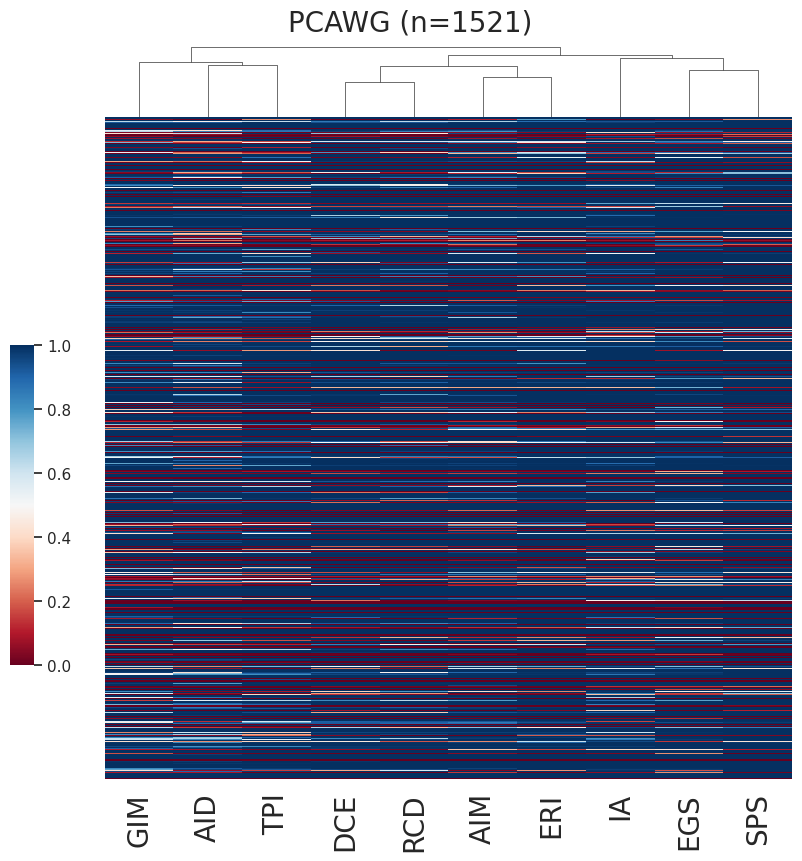

In [121]:
cluster = sns.clustermap(pcawg_pred_df.sample(frac=1, random_state=42), annot=False, cmap = 'RdBu', vmin=0, vmax=1, figsize=(8, 8),
               annot_kws={"size": 35}, row_cluster=False, cbar_kws={"shrink": 1}, dendrogram_ratio=0.1,
                        cbar_pos=(0, .2, .03, .4), yticklabels=False)
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90)
cluster.fig.suptitle("PCAWG (n=1521)", fontsize=20, y=1.02)
plt.savefig('pcawg_pred_heat.png', dpi=1200, bbox_inches='tight')

In [468]:
pcawg_pred_df.to_csv('pcawg_pred.csv')

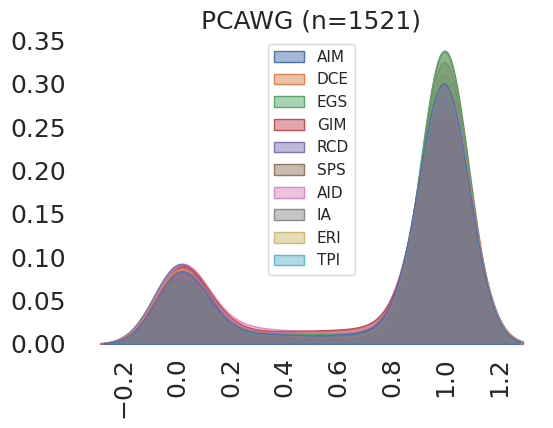

In [64]:
sns.set_theme(style="white")
plt.figure(figsize=(6, 4))

sns.kdeplot(pcawg_pred_df, fill=True, alpha=0.5, linewidth=1)
# plt.xlabel("Predicted Probability", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=16, labelpad=10)
plt.title("PCAWG (n=1521)", fontsize=18, pad=5)

plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

sns.despine(left=True, bottom=True)
# plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.savefig('PCAWG_kde.png', dpi=1200, bbox_inches='tight')
plt.show()

# Model Specificity (true negative rate) check on normal GSE120795 datasets

In [67]:
gse_gene = pd.read_csv('Human.GRCh38.p13.annot.tsv', sep='\t', index_col=0, low_memory=False)
gse_gene = gse_gene[['Symbol']].dropna()
gse_gene

,Symbol
GeneID,
100287102,DDX11L1
653635,WASH7P
102466751,MIR6859-1
107985730,MIR1302-2HG
100302278,MIR1302-2
...,...
4541,ND6
4556,TRNE
4519,CYTB


In [68]:
gse = pd.read_csv('GSE120795_normal.tsv', index_col=0, sep='\t')
gse = pd.concat([gse_gene, gse], axis=1).dropna().set_index('Symbol')
gse

,GSM3415755,GSM3415756,GSM3415757,GSM3415758,GSM3415760,GSM3415761,GSM3415762,GSM3415764,GSM3415767,GSM3415768,...,GSM3415892,GSM3415893,GSM3415894,GSM3415895,GSM3415913,GSM3415914,GSM3415915,GSM3415916,GSM3415917,GSM3415918
Symbol,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.2025,0.2866,0.08907,0.000,0.000,0.231,0.2777,0.1697,0.5388,0.0664,...,0.2907,0.493,0.2491,0.379,0.1907,0.1866,0.227,0.3792,0.2276,0.2857
WASH7P,6.2390,5.1740,6.15500,9.118,2.314,3.344,5.8360,3.4870,3.4380,1.8600,...,12.0300,9.632,7.2120,10.260,4.4830,4.3560,4.557,7.1890,6.2860,5.4550
MIR6859-1,2.4590,4.6410,2.16400,0.000,4.300,0.000,6.7470,2.0620,2.1820,1.6130,...,8.6310,9.213,9.0780,6.906,1.5450,1.5110,1.838,6.4490,6.3200,5.3990
MIR1302-2HG,0.0000,0.0000,0.00000,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000
MIR1302-2,0.0000,0.0000,0.00000,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,2048.0000,3138.0000,3417.00000,7794.000,10100.000,3309.000,15110.0000,8009.0000,438.0000,2130.0000,...,1859.0000,2273.000,5543.0000,2661.000,3651.0000,3083.0000,3168.000,21460.0000,25020.0000,27460.0000
TRNE,38.7800,22.8700,49.05000,167.000,120.800,182.500,322.5000,186.9000,17.2000,38.1500,...,81.9600,69.910,67.1000,228.400,231.4000,218.2000,192.900,431.3000,933.5000,679.6000
CYTB,5431.0000,8274.0000,6412.00000,10100.000,26430.000,11620.000,22100.0000,20760.0000,1807.0000,4445.0000,...,3026.0000,5352.000,10430.0000,4607.000,2979.0000,2730.0000,2857.000,38980.0000,42500.0000,50050.0000


In [69]:
gse1 = gse.T
gse1 = gse1.loc[:, ~gse1.columns.duplicated(keep='first')]
gse1 = gse1.reindex(columns = feature_name, fill_value = 0).fillna(0)
gse1_index = gse1.index
gse1 = rankdata(gse1 * -1, axis=1, method='average')
gse1 = np.log2(gse1 )
gse1 = scaler.transform(gse1)
gse1

array([[ 0.95197729,  0.68678787, -1.3271382 , ...,  0.89337125,
         1.12186798, -0.56742869],
       [ 0.43150579,  0.71836438, -1.83336057, ..., -1.29174853,
         0.69508651, -0.07887676],
       [ 0.45047039,  0.3883165 , -0.02159088, ..., -1.02032895,
         0.97161755, -0.49003504],
       ...,
       [-0.29671345,  0.90808408, -0.97231667, ..., -3.82658771,
        -0.32096517,  0.4454414 ],
       [-0.04390617,  1.06151276, -1.08920333, ..., -3.62993783,
         0.15145911,  0.40494045],
       [-0.09122604,  1.04276961, -1.03060207, ..., -3.67964312,
        -0.31882243,  0.45298818]])

In [70]:
gse_pred = model.predict(gse1)
gse_pred_df = pd.DataFrame()

for task_id in range(10):
    pred = np.array(gse_pred[task_id]).flatten()
    gse_pred_df[f'task_{task_id}'] = pred

gse_pred_df.columns = hall_list
gse_pred_df.index = gse1_index
gse_pred_df

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step


,AIM,DCE,EGS,GIM,RCD,SPS,AID,IA,ERI,TPI
GSM3415755,0.001208,9.586941e-04,3.835462e-02,2.392809e-04,4.193989e-03,3.691732e-05,0.008803,0.015582,3.271399e-03,0.003365
GSM3415756,0.994994,9.909272e-01,9.992566e-01,8.615237e-01,9.997589e-01,9.842354e-01,0.544506,0.998350,9.992630e-01,0.998172
GSM3415757,0.999815,9.997986e-01,9.999703e-01,9.975283e-01,9.999921e-01,9.998227e-01,0.935479,0.999991,9.999515e-01,0.999913
GSM3415758,0.000002,1.368257e-07,7.617133e-06,2.231490e-07,2.168428e-06,1.243729e-07,0.000121,0.000044,1.257304e-06,0.000013
GSM3415760,0.000001,1.085980e-08,1.306041e-07,7.439869e-11,7.414408e-07,1.542123e-09,0.000002,0.000007,1.453493e-08,0.000009
...,...,...,...,...,...,...,...,...,...,...
GSM3415914,1.000000,1.000000e+00,9.999999e-01,9.999794e-01,9.999999e-01,9.999999e-01,0.997390,1.000000,1.000000e+00,0.999999
GSM3415915,0.999999,1.000000e+00,9.999999e-01,9.999826e-01,9.999998e-01,9.999999e-01,0.997449,1.000000,1.000000e+00,0.999999
GSM3415916,0.000035,2.654341e-06,4.480621e-06,5.727732e-05,2.515262e-04,6.398850e-06,0.003544,0.001069,3.316019e-04,0.000107
GSM3415917,0.000181,2.498483e-05,3.163845e-05,2.887182e-04,7.666807e-04,6.952052e-05,0.014501,0.013012,1.256415e-03,0.000523


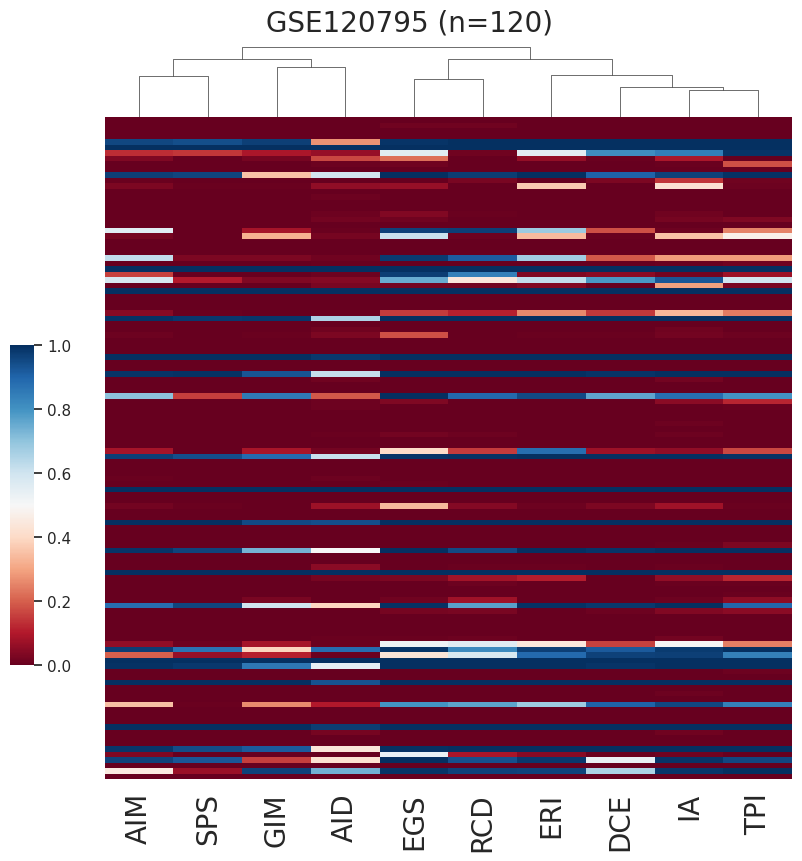

In [122]:
cluster = sns.clustermap(gse_pred_df.sample(frac=1, random_state=42), annot=False, cmap = 'RdBu', vmin=0, vmax=1, figsize=(8, 8),
               annot_kws={"size": 35}, row_cluster=False, cbar_kws={"shrink": 1}, dendrogram_ratio=0.1,
                        cbar_pos=(0, .2, .03, .4), yticklabels=False)
cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xticklabels(), fontsize=20, rotation=90)
cluster.fig.suptitle("GSE120795 (n=120)", fontsize=20, y=1.02)
plt.savefig('gse_pred_heat.png', dpi=1200, bbox_inches='tight')

In [72]:
gse_pred_df.to_csv('GSE120795_pred.csv')

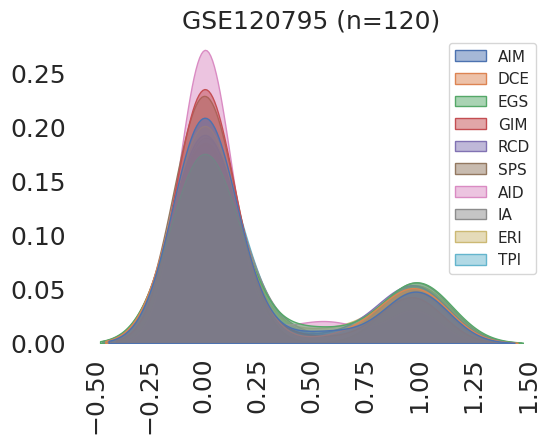

In [73]:
sns.set_theme(style="white")
plt.figure(figsize=(6, 4))

sns.kdeplot(gse_pred_df, fill=True, alpha=0.5, linewidth=1)
# plt.xlabel("Predicted Probability", fontsize=16, labelpad=10)
plt.ylabel("", fontsize=16, labelpad=10)
plt.title("GSE120795 (n=120)", fontsize=18, pad=5)

plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)

sns.despine(left=True, bottom=True)
# plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.savefig('GSE120795_kde.png', dpi=1200, bbox_inches='tight')
plt.show()